In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


In [2]:
#Used pmdarima to obtain P,D,Q values automatically using AutoARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.8 MB/s eta 0:00:00


In [3]:
#Import TA-lib library as it has wide range of technical indicators like RSI which we used for Feature Engineering
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 107763 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 13.6 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... - \ | / done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for ta-lib: filename=TA_Lib-0.4.28-cp310-cp310-linux_x86_64.whl size=497490 sha256=5a38c706f4c141e0fd75d19eacf81737984ee3fc103b77e9f48ce1ff59121bad
  Stored in directory: /ro

# Pre-processing the Data

In [4]:
# Necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from datetime import datetime
import talib
import matplotlib.pyplot as plt
import pandas as pd


# Loading the datasets
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

In [5]:
# Convert the 'Date' column to a datetime data type
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Set the 'Date' column as the index for both DataFrames
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)

In [6]:
train.head()

,Open,Close,Volume,Strategy
Date,,,,
2015-06-01,66.208486,75.609978,298506300,Hold
2015-06-08,64.116235,74.443331,227974800,Hold
2015-06-15,47.701942,71.140831,250670900,Buy
2015-06-22,54.754816,72.881344,223614300,Hold
2015-06-29,48.031899,66.284718,406814900,Buy


In [7]:
#Checking for null values
train.isnull().sum()
#No null values, so no further data cleaning

Open        0
Close       0
Volume      0
Strategy    0
dtype: int64

In [8]:
df=pd.concat([train,test])
df

,Open,Close,Volume,Strategy
Date,,,,
2015-06-01,66.208486,75.609978,298506300,Hold
2015-06-08,64.116235,74.443331,227974800,Hold
2015-06-15,47.701942,71.140831,250670900,Buy
2015-06-22,54.754816,72.881344,223614300,Hold
2015-06-29,48.031899,66.284718,406814900,Buy
...,...,...,...,...
2022-12-26,57.048622,NaN,224994700,NaN
2023-01-02,60.569661,NaN,176020500,NaN
2023-01-09,61.446777,NaN,181478600,NaN


# Exploratory Data Analysis
**ADF and KPSS tests**

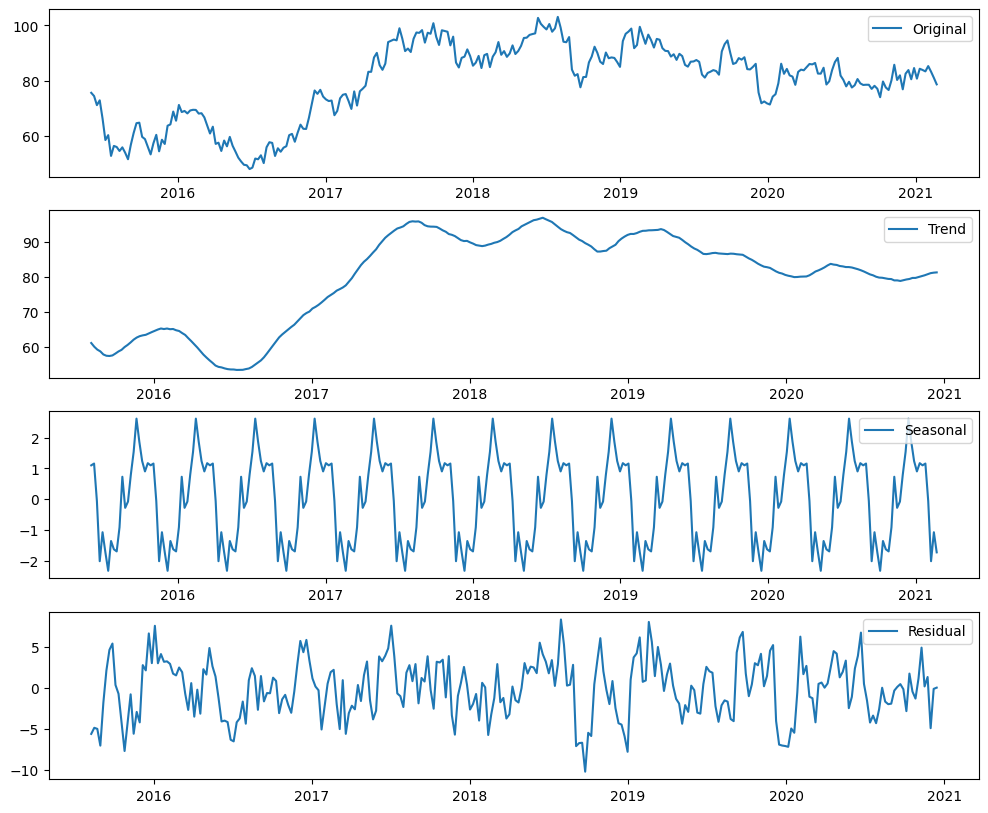

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(train['Close'], model='additive', period=21) 

# Plot the decomposed components
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(train['Close'], label='Original')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.show()

The above code is useful for visually inspecting the individual components of a time series, which can help in understanding the underlying patterns and trends, as well as identifying any seasonality or residuals. It's a common step in time series analysis and forecasting.

In [10]:
# ADF Test for Stationarity
result_adf = adfuller(train['Close'])
print("ADF Test:")
print("ADF Statistic: ", result_adf[0])
print("p-value: ", result_adf[1])
print("Critical Values: ", result_adf[4])

# KPSS Test for Stationarity
result_kpss = kpss(train['Close'])
print("\nKPSS Test:")
print("KPSS Statistic: ", result_kpss[0])
print("p-value: ", result_kpss[1])
print("Critical Values: ", result_kpss[3])

# Determine stationarity
if result_adf[1] <= 0.05:
    print("ADF test: The time series is stationary")
else:
    print("ADF test: The time series is not stationary")

if result_kpss[1] >= 0.05:
    print("KPSS test: The time series is stationary")
else:
    print("KPSS test: The time series is not stationary")


ADF Test:
ADF Statistic:  -1.8080055426222836
p-value:  0.37649446979222034
Critical Values:  {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}

KPSS Test:
KPSS Statistic:  1.3000076924249166
p-value:  0.01
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
ADF test: The time series is not stationary
KPSS test: The time series is not stationary


* The ADF Statistic is -1.808, which is less than the critical values at all significance levels (1%, 5%, and 10%). The p-value is 0.376, which is greater than the common significance level of 0.05. Based on the ADF test results, the null hypothesis is not rejected, suggesting that the time series is not stationary. This means the data likely has a unit root, indicating a non-stationary process.
* The KPSS Statistic is 1.300, which is greater than the critical values at all significance levels (1%, 2.5%, 5%, and 10%). The p-value is 0.01, which is less than the common significance level of 0.05. Based on the KPSS test results, the null hypothesis is rejected, suggesting that the time series is not stationary. This indicates that the data has a deterministic trend or a structural break.
* In summary, both the ADF and KPSS tests agree that the time series is not stationary. The ADF test suggests non-stationarity due to the presence of a unit root, while the KPSS test suggests non-stationarity due to a deterministic trend or structural break. These results indicate that we must apply differencing or other transformations to make the time series stationary before using it in time series analysis or modeling.

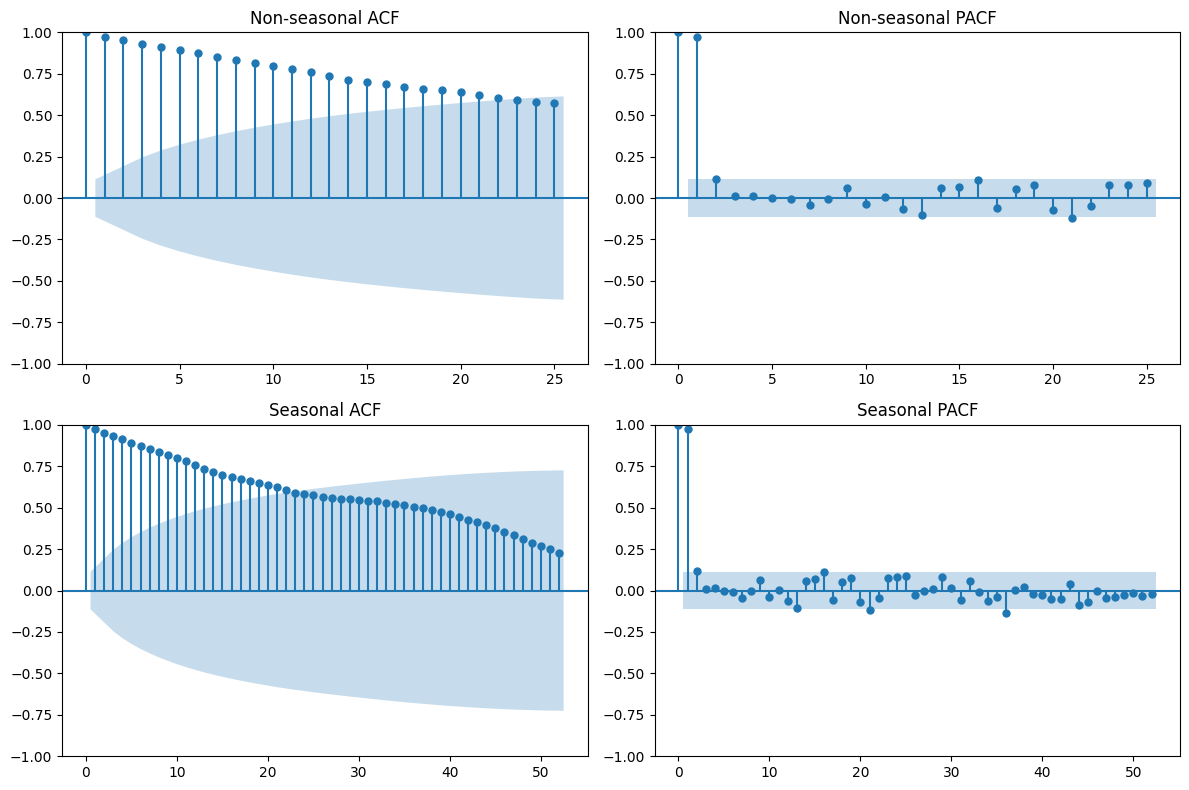

In [11]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Load your time series data
# Replace 'data' with your actual time series data
data = train['Close']
# Non-seasonal ACF and PACF
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Non-seasonal ACF
plot_acf(data, ax=ax[0, 0])
ax[0, 0].set_title('Non-seasonal ACF')

# Non-seasonal PACF
plot_pacf(data, ax=ax[0, 1])
ax[0, 1].set_title('Non-seasonal PACF')

# Seasonal ACF
plot_acf(data, lags=52, ax=ax[1, 0])  # Adjust the number of lags based on the seasonal period (52 for weekly data)
ax[1, 0].set_title('Seasonal ACF')

# Seasonal PACF
plot_pacf(data, lags=52, ax=ax[1, 1])  # Adjust the number of lags based on the seasonal period
ax[1, 1].set_title('Seasonal PACF')

plt.tight_layout()
plt.show()


* ACF plots display the correlation between each observation and its lagged values. This helps in understanding how each data point is related to past observations. PACF plots focus on the direct and indirect relationships at different lags, which is crucial for determining the AR order.
* ACF and PACF plots can be used to identify the order of differencing needed to make a time series stationary. Differencing removes trends and can help stabilize the series for modeling.

# Feature Engineering
**Due to limited parameters in the given dataset, it was crucial to perform Feature Engineering to obtain relevant parameters to help build and train our models**

In [12]:
#Day, Month and Year
df['Date'] = pd.to_datetime(df.index)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Calculating technical indicators, moving averages and lagged variables
df['SMA_4'] = df['Open'].rolling(window=4).mean()
df['SMA_12'] = df['Open'].rolling(window=12).mean()
df['RSI'] = talib.RSI(df['Open'].values, timeperiod=12)
df['Open_Lag_1'] = df['Open'].shift(1)
df['Volume_Lag_1'] = df['Volume'].shift(1)

df['Pct_Change_SMA_4_12'] = (df['SMA_4'] - df['SMA_12']) / df['SMA_12']

df['Volatility_2'] = df['Open'].rolling(window=2).std()

#Adding Bollinger variables
df['Bollinger_Band_Middle'] = df['Open'].rolling(window=2).mean()
df['Bollinger_Band_Upper'] = df['Bollinger_Band_Middle'] + 2 * df['Volatility_2']
df['Bollinger_Band_Lower'] = df['Bollinger_Band_Middle'] - 2 * df['Volatility_2']

df['Close_vs_SMA_4'] = df['Open'] - df['SMA_4']
df['Close_vs_SMA_12'] = df['Open'] - df['SMA_12']


In [13]:
#Dropeed first 14 values because they became NA while calculating Rolling average and other features
df = df.iloc[14:]
df

,Open,Close,Volume,Strategy,Date,Year,Month,Day,SMA_4,SMA_12,RSI,Open_Lag_1,Volume_Lag_1,Pct_Change_SMA_4_12,Volatility_2,Bollinger_Band_Middle,Bollinger_Band_Upper,Bollinger_Band_Lower,Close_vs_SMA_4,Close_vs_SMA_12
Date,,,,,,,,,,,,,,,,,,,,
2015-09-07,56.326397,56.777579,447136100,Hold,2015-09-07,2015,9,7,57.045912,51.135645,43.065988,61.833756,272386700.0,0.115580,3.894291,59.080077,66.868658,51.291495,-0.719514,5.190752
2015-09-14,52.248914,61.065344,316464700,Hold,2015-09-14,2015,9,14,57.233721,50.926820,40.283465,56.326397,447136100.0,0.123842,2.883217,54.287655,60.054089,48.521222,-4.984807,1.322094
2015-09-21,54.227949,64.600725,338811600,Hold,2015-09-21,2015,9,21,56.159254,51.443157,42.258797,52.248914,316464700.0,0.091676,1.399389,53.238431,56.037209,50.439653,-1.931305,2.784791
2015-09-28,47.522017,64.788118,498604400,Hold,2015-09-28,2015,9,28,52.581319,51.122125,37.654564,54.227949,338811600.0,0.028543,4.741810,50.874983,60.358602,41.391363,-5.059302,-3.600109
2015-10-05,47.821994,59.648427,303670600,Hold,2015-10-05,2015,10,5,50.455218,51.286344,37.984295,47.522017,498604400.0,-0.016206,0.212116,47.672005,48.096237,47.247773,-2.633224,-3.464350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,57.048622,NaN,224994700,NaN,2022-12-26,2022,12,26,57.519659,56.931817,45.675504,55.184092,291865900.0,0.010325,1.318422,56.116357,58.753201,53.479513,-0.471037,0.116805
2023-01-02,60.569661,NaN,176020500,NaN,2023-01-02,2023,1,2,57.805033,56.488577,51.547292,57.048622,224994700.0,0.023305,2.489750,58.809142,63.788642,53.829641,2.764628,4.081084
2023-01-09,61.446777,NaN,181478600,NaN,2023-01-09,2023,1,9,58.562288,56.821261,52.929886,60.569661,176020500.0,0.030640,0.620215,61.008219,62.248648,59.767790,2.884489,4.625516


In [14]:
#Much better tehe :)
df

,Open,Close,Volume,Strategy,Date,Year,Month,Day,SMA_4,SMA_12,RSI,Open_Lag_1,Volume_Lag_1,Pct_Change_SMA_4_12,Volatility_2,Bollinger_Band_Middle,Bollinger_Band_Upper,Bollinger_Band_Lower,Close_vs_SMA_4,Close_vs_SMA_12
Date,,,,,,,,,,,,,,,,,,,,
2015-09-07,56.326397,56.777579,447136100,Hold,2015-09-07,2015,9,7,57.045912,51.135645,43.065988,61.833756,272386700.0,0.115580,3.894291,59.080077,66.868658,51.291495,-0.719514,5.190752
2015-09-14,52.248914,61.065344,316464700,Hold,2015-09-14,2015,9,14,57.233721,50.926820,40.283465,56.326397,447136100.0,0.123842,2.883217,54.287655,60.054089,48.521222,-4.984807,1.322094
2015-09-21,54.227949,64.600725,338811600,Hold,2015-09-21,2015,9,21,56.159254,51.443157,42.258797,52.248914,316464700.0,0.091676,1.399389,53.238431,56.037209,50.439653,-1.931305,2.784791
2015-09-28,47.522017,64.788118,498604400,Hold,2015-09-28,2015,9,28,52.581319,51.122125,37.654564,54.227949,338811600.0,0.028543,4.741810,50.874983,60.358602,41.391363,-5.059302,-3.600109
2015-10-05,47.821994,59.648427,303670600,Hold,2015-10-05,2015,10,5,50.455218,51.286344,37.984295,47.522017,498604400.0,-0.016206,0.212116,47.672005,48.096237,47.247773,-2.633224,-3.464350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,57.048622,NaN,224994700,NaN,2022-12-26,2022,12,26,57.519659,56.931817,45.675504,55.184092,291865900.0,0.010325,1.318422,56.116357,58.753201,53.479513,-0.471037,0.116805
2023-01-02,60.569661,NaN,176020500,NaN,2023-01-02,2023,1,2,57.805033,56.488577,51.547292,57.048622,224994700.0,0.023305,2.489750,58.809142,63.788642,53.829641,2.764628,4.081084
2023-01-09,61.446777,NaN,181478600,NaN,2023-01-09,2023,1,9,58.562288,56.821261,52.929886,60.569661,176020500.0,0.030640,0.620215,61.008219,62.248648,59.767790,2.884489,4.625516


In [15]:
#286 onwards is from test file
df.iloc[285]

Open                                69.61862
Close                              78.672007
Volume                             332979200
Strategy                                Hold
Date                     2021-02-22 00:00:00
Year                                    2021
Month                                      2
Day                                       22
SMA_4                              70.686457
SMA_12                             77.072628
RSI                                34.345163
Open_Lag_1                         69.372333
Volume_Lag_1                     167762500.0
Pct_Change_SMA_4_12                -0.082859
Volatility_2                        0.174151
Bollinger_Band_Middle              69.495477
Bollinger_Band_Upper               69.843779
Bollinger_Band_Lower               69.147174
Close_vs_SMA_4                     -1.067837
Close_vs_SMA_12                    -7.454008
Name: 2021-02-22 00:00:00, dtype: object

In [16]:
split_index=286
s_train = df.iloc[:split_index]
s_test = df.iloc[split_index:]
s_train.tail()

,Open,Close,Volume,Strategy,Date,Year,Month,Day,SMA_4,SMA_12,RSI,Open_Lag_1,Volume_Lag_1,Pct_Change_SMA_4_12,Volatility_2,Bollinger_Band_Middle,Bollinger_Band_Upper,Bollinger_Band_Lower,Close_vs_SMA_4,Close_vs_SMA_12
Date,,,,,,,,,,,,,,,,,,,,
2021-01-25,81.284821,83.373498,117281600,Sell,2021-01-25,2021,1,25,80.569815,79.473162,57.740050,80.663736,127248000.0,0.013799,0.439173,80.974279,81.852625,80.095932,0.715006,1.811660
2021-02-01,71.970249,85.294903,177655800,Sell,2021-02-01,2021,2,1,78.439755,79.184205,37.523733,81.284821,117281600.0,-0.009401,6.586397,76.627535,89.800329,63.454741,-6.469506,-7.213956
2021-02-08,71.784627,83.266453,146003500,Hold,2021-02-08,2021,2,8,76.425859,78.625456,37.240272,71.970249,177655800.0,-0.027976,0.131255,71.877438,72.139948,71.614929,-4.641231,-6.840829
2021-02-15,69.372333,81.026827,167762500,Hold,2021-02-15,2021,2,15,73.603008,77.832920,33.637777,71.784627,146003500.0,-0.054346,1.705750,70.578480,73.989979,67.166981,-4.230675,-8.460587
2021-02-22,69.618620,78.672007,332979200,Hold,2021-02-22,2021,2,22,70.686457,77.072628,34.345163,69.372333,167762500.0,-0.082859,0.174151,69.495477,69.843779,69.147174,-1.067837,-7.454008


# PART 1: SARIMA for Close price prediction
* **Inferring from our EDA, and trying other models, we came to the conclusion that we will use SARIMAX for building our Prediction Model**
* **Due to the presence of exogenous variables, we used SARIMAX instead of SARIMA**

In [17]:
def train_Sarima(train_data):
    arima_model = auto_arima(train['Close'], seasonal=True, m=52) 
    # Get the best SARIMA parameters
    best_order = arima_model.order
    best_seasonal_order = arima_model.seasonal_order

    # Fit the SARIMA model with the best parameters
    print(best_order,best_seasonal_order)
#     sarima_model = SARIMAX(train['Close'], order=best_order, seasonal_order=best_seasonal_order)
#     sarima_result = sarima_model.fit()
    #return sarima_result

In [18]:
train_Sarima(s_train)

(0, 1, 1) (0, 0, 0, 52)


Obtained best order and best seasonal order values by decreasing AIC value

In [19]:
# SARIMA model for Close price prediction
def train_sarima(train_data):
    exog_vars = train_data[['Day','Open_Lag_1','Volume_Lag_1','Month','Volume', 'SMA_4', 'SMA_12', 'Pct_Change_SMA_4_12', 'Volatility_2',
                            'Close_vs_SMA_4','Close_vs_SMA_12']]
    
    # Best AIC: 958.5518862917913 with parameters: ((1, 1, 1), (0, 1, 1, 52))
    #011 000 pmdarima
    model = SARIMAX(train_data['Close'],exog=exog_vars,order=(0,1,1), seasonal_order=(0, 0 ,0 ,52)) 

    model_fit = model.fit(disp=False)
    return model_fit

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Make predictions using SARIMA model
exog_vars = s_test[['Day','Open_Lag_1','Volume_Lag_1','Month','Volume', 'SMA_4', 'SMA_12', 'Pct_Change_SMA_4_12',
                    'Volatility_2','Close_vs_SMA_4','Close_vs_SMA_12']]
sarima_model = train_sarima(s_train)
sarima_forecast = sarima_model.forecast(steps=len(s_test),exog=exog_vars)
sarima_forecast

2021-03-01    77.284675
2021-03-08    76.676723
2021-03-15    77.687258
2021-03-22    78.459589
2021-03-29    77.585628
                ...    
2022-12-26    66.402027
2023-01-02    65.273214
2023-01-09    65.228204
2023-01-16    67.087142
2023-01-23    68.187194
Freq: W-MON, Name: predicted_mean, Length: 100, dtype: float64

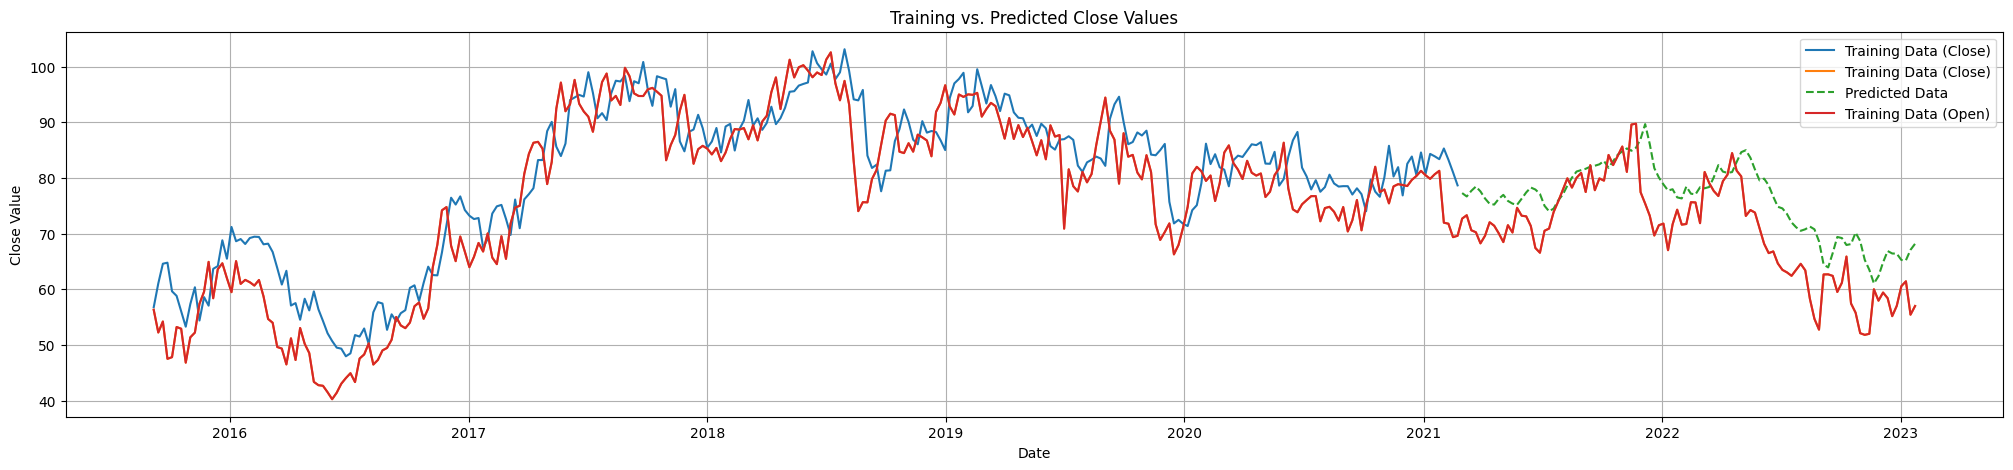

In [21]:
# Create the plot to check our SARIMAX model
plt.figure(figsize=(25, 5))
plt.plot(df.index, df[['Close','Open']], label='Training Data (Close)')
plt.plot(s_test.index, sarima_forecast, label='Predicted Data', linestyle='--')
plt.plot(df.index, df[['Open']], label='Training Data (Open)')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Training vs. Predicted Close Values')
plt.legend()
plt.grid(True)
plt.show()


The green dotted line depicts our preditcion

In [22]:
prediction=pd.DataFrame({'Date':s_test.index,'Close':sarima_forecast})
prediction.set_index('Date')

,Close
Date,
2021-03-01,77.284675
2021-03-08,76.676723
2021-03-15,77.687258
2021-03-22,78.459589
2021-03-29,77.585628
...,...
2022-12-26,66.402027
2023-01-02,65.273214
2023-01-09,65.228204


In [23]:
#Updating our predicted Close values onto the combined Dataframe
df['Close'].iloc[-100:] = prediction['Close']
df

,Open,Close,Volume,Strategy,Date,Year,Month,Day,SMA_4,SMA_12,RSI,Open_Lag_1,Volume_Lag_1,Pct_Change_SMA_4_12,Volatility_2,Bollinger_Band_Middle,Bollinger_Band_Upper,Bollinger_Band_Lower,Close_vs_SMA_4,Close_vs_SMA_12
Date,,,,,,,,,,,,,,,,,,,,
2015-09-07,56.326397,56.777579,447136100,Hold,2015-09-07,2015,9,7,57.045912,51.135645,43.065988,61.833756,272386700.0,0.115580,3.894291,59.080077,66.868658,51.291495,-0.719514,5.190752
2015-09-14,52.248914,61.065344,316464700,Hold,2015-09-14,2015,9,14,57.233721,50.926820,40.283465,56.326397,447136100.0,0.123842,2.883217,54.287655,60.054089,48.521222,-4.984807,1.322094
2015-09-21,54.227949,64.600725,338811600,Hold,2015-09-21,2015,9,21,56.159254,51.443157,42.258797,52.248914,316464700.0,0.091676,1.399389,53.238431,56.037209,50.439653,-1.931305,2.784791
2015-09-28,47.522017,64.788118,498604400,Hold,2015-09-28,2015,9,28,52.581319,51.122125,37.654564,54.227949,338811600.0,0.028543,4.741810,50.874983,60.358602,41.391363,-5.059302,-3.600109
2015-10-05,47.821994,59.648427,303670600,Hold,2015-10-05,2015,10,5,50.455218,51.286344,37.984295,47.522017,498604400.0,-0.016206,0.212116,47.672005,48.096237,47.247773,-2.633224,-3.464350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,57.048622,66.402027,224994700,NaN,2022-12-26,2022,12,26,57.519659,56.931817,45.675504,55.184092,291865900.0,0.010325,1.318422,56.116357,58.753201,53.479513,-0.471037,0.116805
2023-01-02,60.569661,65.273214,176020500,NaN,2023-01-02,2023,1,2,57.805033,56.488577,51.547292,57.048622,224994700.0,0.023305,2.489750,58.809142,63.788642,53.829641,2.764628,4.081084
2023-01-09,61.446777,65.228204,181478600,NaN,2023-01-09,2023,1,9,58.562288,56.821261,52.929886,60.569661,176020500.0,0.030640,0.620215,61.008219,62.248648,59.767790,2.884489,4.625516


# Checking Feature Importance as part of Feature Engineering:

Top Important Features:
17          Close_vs_SMA_12
1                     Close
11      Pct_Change_SMA_4_12
8                       RSI
16           Close_vs_SMA_4
6                     SMA_4
7                    SMA_12
13    Bollinger_Band_Middle
14     Bollinger_Band_Upper
15     Bollinger_Band_Lower
4                     Month
0                      Open
9                Open_Lag_1
2                    Volume
12             Volatility_2
10             Volume_Lag_1
5                       Day
3                      Year
Name: Feature, dtype: object


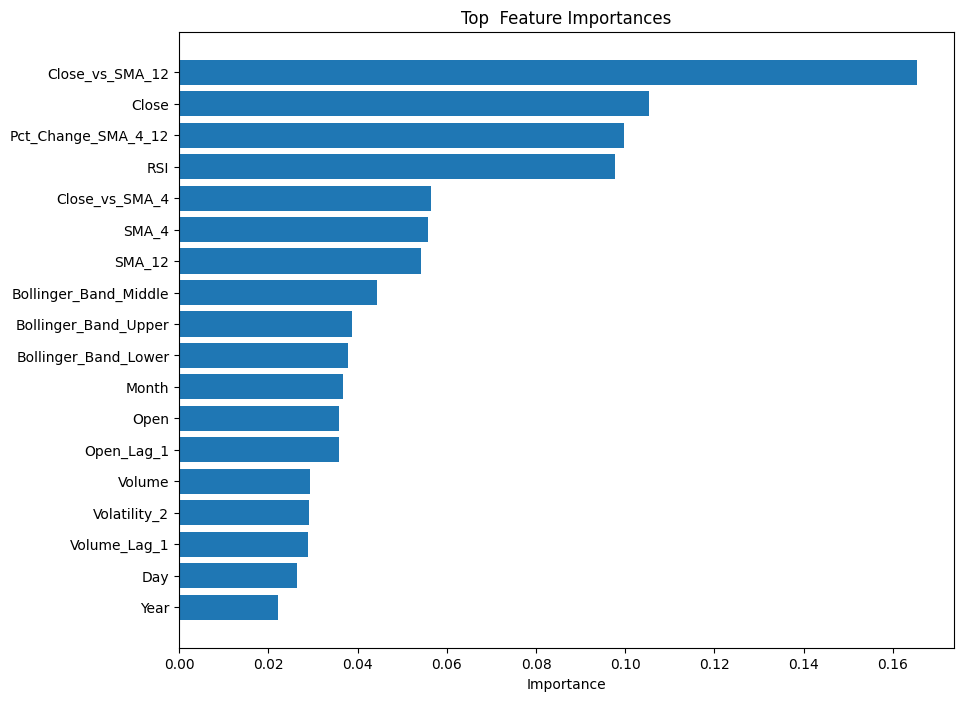

In [24]:
# Feature importance using RandomForestClassifier
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

#creating a dataframe to store train.csv
data = s_train
data['Close_vs_SMA_4'] = data['Close'] - data['SMA_4']
data['Close_vs_SMA_12'] = data['Close'] - data['SMA_12']

# Separate features and target variable
X = data.drop(columns=['Strategy','Date'])  
y = data['Strategy']  # Target variable

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Here we are creating a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Printing most important features
top_features = feature_importance_df['Feature'][:]
print("Top Important Features:")
print(top_features)

# Plot the feature importances for the top features
plt.figure(figsize=(10, 8))
plt.barh(top_features, feature_importance_df['Importance'][:])
plt.xlabel('Importance')
plt.title('Top  Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()

In [25]:
s_train['Close_vs_SMA_4'] = s_train['Close'] - s_train['SMA_4']
s_train['Close_vs_SMA_12'] = s_train['Close'] - s_train['SMA_12']

In [26]:
# Splitting the data for training
from sklearn.model_selection import train_test_split
X = s_train.drop(columns=['Strategy','Date','Volume','Volatility_2','Volume_Lag_1','Day','Year','Bollinger_Band_Middle','Bollinger_Band_Upper','Bollinger_Band_Lower'])
#Dropped these columns because they had less relative importance
Y = s_train['Strategy']
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:286], Y.iloc[:286], test_size=0.15, stratify=Y, random_state=42)
X_train

,Open,Close,Month,SMA_4,SMA_12,RSI,Open_Lag_1,Pct_Change_SMA_4_12,Close_vs_SMA_4,Close_vs_SMA_12
Date,,,,,,,,,,
2017-08-14,94.737615,97.461917,8,96.157622,93.746971,59.255447,93.918216,0.025714,1.304295,3.714946
2018-02-26,88.964096,90.288241,2,88.364424,85.784825,52.088167,88.686967,0.030071,1.923818,4.503416
2020-09-28,70.599723,77.087868,9,72.362388,73.800342,41.914302,76.050459,-0.019484,4.725480,3.287527
2020-08-10,74.817766,80.594621,8,74.592623,76.732949,44.818496,74.594197,-0.027893,6.001999,3.861673
2016-01-11,65.073001,68.638750,1,62.811191,58.800510,55.913376,59.491598,0.068208,5.827559,9.838240
...,...,...,...,...,...,...,...,...,...,...
2015-10-19,52.929424,56.049316,10,50.377363,52.249869,43.579059,53.236019,-0.035838,5.671952,3.799447
2017-08-28,99.787780,98.324280,8,95.387689,94.387155,63.755033,93.107145,0.010600,2.936591,3.937125
2017-01-09,65.839230,72.623524,1,66.522991,65.936817,57.420547,63.982040,0.008890,6.100533,6.686707


# **PART 2: Random Forest Classifier for Strategy classification**
* **Since the dataset was small, simpler models like SVM did not perform well**
* **A Random Forest Classifier is a popular ensemble machine learning model used for classification tasks. It belongs to the broader family of ensemble methods, which combine the predictions of multiple base models (in this case, decision trees) to make more accurate and robust predictions.**
* **Hence we used Random Forest Classifier**


In [27]:
#Scaling our features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300,max_depth=40,random_state=14)

# Train the model on the training data
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate a classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.9069767441860465
              precision    recall  f1-score   support

         Buy       0.90      0.90      0.90        10
        Hold       0.90      0.90      0.90        21
        Sell       0.92      0.92      0.92        12

    accuracy                           0.91        43
   macro avg       0.91      0.91      0.91        43
weighted avg       0.91      0.91      0.91        43



In [29]:
s_test['Close_vs_SMA_4'] = s_test['Close'] - s_test['SMA_4']
s_test['Close_vs_SMA_12'] = s_test['Close'] - s_test['SMA_12']
test2=scaler.fit_transform(s_test.drop(columns=['Strategy','Date','Volume','Volatility_2','Volume_Lag_1','Day','Year','Bollinger_Band_Middle','Bollinger_Band_Upper','Bollinger_Band_Lower']))
y_pred=clf.predict(test2)
y_pred

array(['Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Sell', 'Hold', 'Buy', 'Buy', 'Buy', 'Hold', 'Sell', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Hold', 'Sell', 'Sell',
       'Hold', 'Hold', 'Sell', 'Sell', 'Sell', 'Hold', 'Hold', 'Sell',
       'Sell', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Sell', 'Sell', 'Sell', 'Sell', 'Hold', 'Hold',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Hold', 'Hold',
       'Hold', 'Sell', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold'],
      dtype=object)

In [30]:
newD=df['Date'].iloc[-100:]
newD

Date
2021-03-01   2021-03-01
2021-03-08   2021-03-08
2021-03-15   2021-03-15
2021-03-22   2021-03-22
2021-03-29   2021-03-29
                ...    
2022-12-26   2022-12-26
2023-01-02   2023-01-02
2023-01-09   2023-01-09
2023-01-16   2023-01-16
2023-01-23   2023-01-23
Name: Date, Length: 100, dtype: datetime64[ns]

# Generating submission.csv

In [31]:
# Generate submission file with predicted Close prices and suggested Strategy
submission = pd.DataFrame()
submission['Date']=newD.to_numpy()
submission['Close']=sarima_forecast.to_numpy()
submission['Strategy']=y_pred
submission['id']=[i for i in range(0,100)]
submission.set_index('id',inplace=True)
submission.to_csv('submission.csv', index=True)
submission

,Date,Close,Strategy
id,,,
0,2021-03-01,77.284675,Buy
1,2021-03-08,76.676723,Buy
2,2021-03-15,77.687258,Buy
3,2021-03-22,78.459589,Hold
4,2021-03-29,77.585628,Hold
...,...,...,...
95,2022-12-26,66.402027,Hold
96,2023-01-02,65.273214,Hold
97,2023-01-09,65.228204,Hold


# THANK YOU :))